# Image Detection with Tensorflow 1.x (GPU Enabled)


In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Enable GPU acceleration by navigating to 

> Edit > Notebook Settings > Choose "GPU" for hardware acceleration.

Then run the cell below to make sure the GPU is setup. You should see 'Found GPU'

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Mount** your google drive my using **'Mount drive'** from the files section.

Compile the model definition. Remember to change to the name of your folder.

In [2]:
%cd /content/drive/My Drive/RoadSignDetection/models/research/

/content/drive/My Drive/RoadSignDetection/models/research


In [0]:
# %cd /content/drive/My Drive/RoadSignDetection/models/research/
# !protoc object_detection/protos/*.proto --python_out=.

Set the environment

In [0]:
import os
os.environ['PYTHONPATH'] += ':/content/drive/My Drive/RoadSignDetection/models/research/:/content/drive/My Drive/RoadSignDetection/models/research/slim'

# By reaching this point the Environment is now setup. 

# Imports

In [0]:
import numpy as np
import os
import tensorflow as tf
import cv2
import time
from google.colab.patches import cv2_imshow
import glob
import csv

In [0]:
# Import the object detection module.
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [46]:
%cd '/content/drive/My Drive/RoadSignDetection/models/research/object_detection'

/content/drive/My Drive/RoadSignDetection/models/research/object_detection


# Model Preparation

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing the path.

In [0]:
MODEL_NAME = 'inference_graph_6'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# Load the Tensorflow model into memory.

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `Speed limit (70km/h)`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [0]:
PATH_TO_LABELS = 'training/label_map.pbtxt'
NUM_CLASSES = 13

# Adding Labels and categories
# Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this
# corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping
# integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Load object detection function

In [0]:
def objectDetection(imagePath, actualCategory):

  image = cv2.imread(imagePath)
  
  image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

  # Each box represents a part of the image where a particular object was detected.
  detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

  # Each score represent how level of confidence for each of the objects.
  # Score is shown on the result image, together with the class label.
  detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
  detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
  num_detections = detection_graph.get_tensor_by_name('num_detections:0')

  # Resize image with aspect ratio
  width = int(image.shape[1])
  height = int(image.shape[0])
  aspectRatio = height / width

  if width < 150:
    width = 150
    height = width * aspectRatio
    image = cv2.resize(image, (int(width), int(height)))
  elif height < 150:
    height = 150
    width = height / aspectRatio
    image = cv2.resize(image, (int(width), int(height)))
  elif width > 300:
    width = 300
    height = width * aspectRatio
    image = cv2.resize(image, (int(width), int(height)))
  elif height > 300:
    height = 300
    width = height / aspectRatio
    image = cv2.resize(image, (int(width), int(height)))

  # Resize image without aspect ratio
  # width = 150
  # height = 150
  # image = cv2.resize(image, (int(width), int(height)))

  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image, axis=0)

  # Actual detection.
  (boxes, scores, classes, num) = sess.run(
      [detection_boxes, detection_scores, detection_classes, num_detections],
      feed_dict={image_tensor: image_np_expanded})
  
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image,
      np.squeeze(boxes),
      np.squeeze(classes).astype(np.int32),
      np.squeeze(scores),
      category_index,
      use_normalized_coordinates=True, 
      line_thickness=3, 
      min_score_thresh=.5)

  # Provides output of the category with higest score
  if [category_index.get(i).get('name') for i in classes[0]][0] == actualCategory:
      # print('CORRECT')
      return 1

  cv2_imshow(image)
  return 0

# Testing Images in the 'test_images folder'

In [39]:
%cd '/content/drive/My Drive/RoadSignDetection/models/research/object_detection'

/content/drive/My Drive/RoadSignDetection/models/research/object_detection


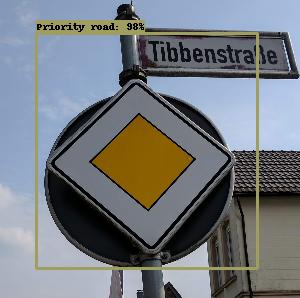

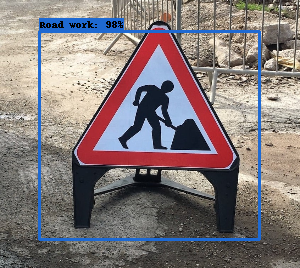

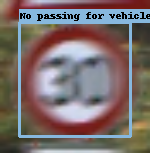

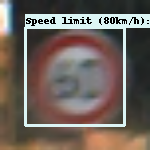

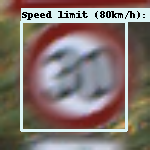

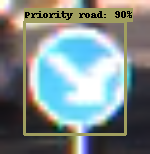

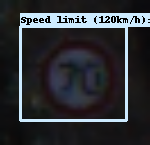

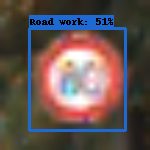

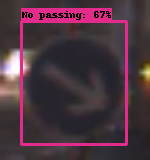

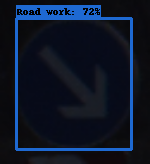

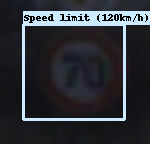

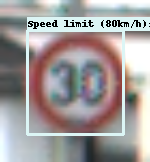

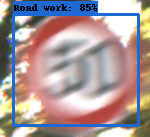

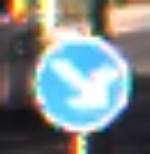

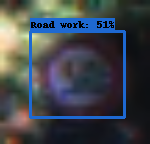

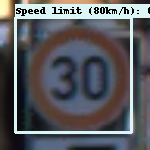

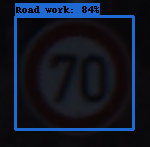

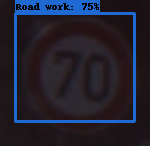

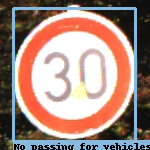

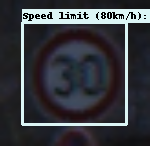

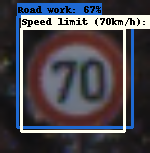

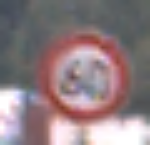

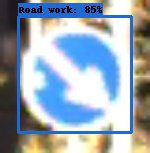

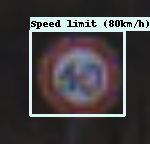

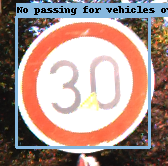

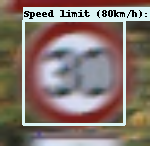

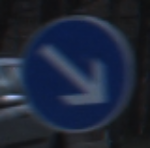

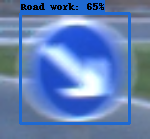

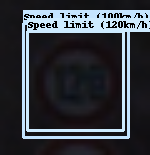

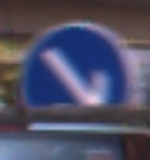

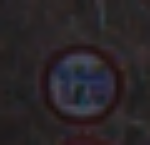

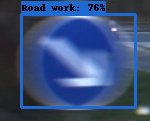

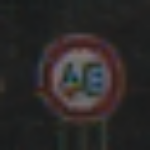

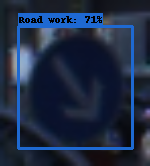

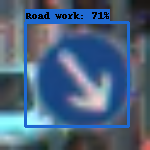

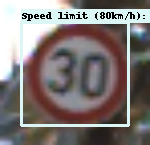

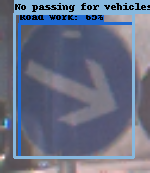

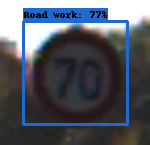

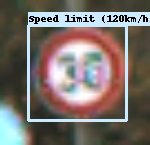

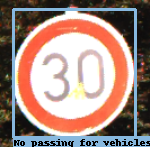

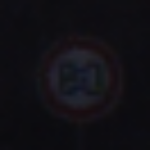

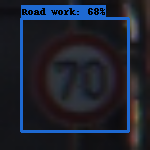

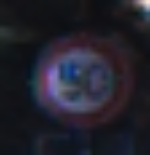

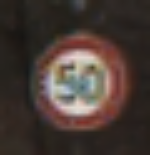

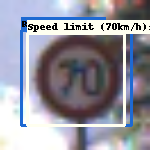

Processed Images per Second:  12.54
Accuracy:  0.71 %


In [50]:
testImagesInfo = {}
with open('test_labels.csv', 'r') as currentfile:
  reader = csv.reader(currentfile)
  next(reader)
  for row in reader:
    testImagesInfo[row[0]] = row[3]

PATH_TO_TEST_IMAGES_DIR = os.chdir('test_images')
TEST_IMAGE_PATHS = glob.glob('*.jpg')
TEST_IMAGE_PATHS.extend(glob.glob('*.png'))
correctDetections = 0
startTime = time.time()
for imagePath in TEST_IMAGE_PATHS:
  correctDetections += objectDetection(imagePath, testImagesInfo.get(imagePath))

endTime = time.time()
print('Processed Images per Second: ', round(150/(endTime - startTime),2))
print('Accuracy: ', round(correctDetections/150,2),'%')
os.chdir("..")